In [6]:
import pandas as pd
import subprocess
from Bio import Entrez, SeqIO
import ast
import os
import numpy as np
from collections import defaultdict
import time
import subprocess

In [7]:
## load chimeras found in > 1 genome
dfc=pd.read_csv("SI tables/SI table 4.tsv",sep="\t",index_col='cluster_id')
single_species=set([x for x in dfc[dfc.n_species==1].q_name])

In [3]:
dfp=pd.read_csv("SI tables/SI table 9.tsv",sep="\t",index_col=0)
## filter by intervals where hgt- and metazoan intervals agree on  the parent gene
dfp=dfp[dfp.min_eval_loc==dfp.tree_parent_gene]
dfp.shape[0]

42

## Obtain trees, nucleotide/protein fastas, protein MSAs, and codon alignments for analysis
Uses previously computed maximum likelihood trees to extract chimeric and non-chimeric relatives of each interval, then produces MSAs and maximum likelihood trees from these sequences

In [1]:
from ete3 import Tree


/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
### takes a datafraame row and returns an origin annotation 
def tax_label(row):
    if 'primary_chimera' in str(row):
        return 'chimera'
    elif 'secondary' in row.index and row['secondary']=="True":
        return 'chimera'
    else:
        return row['order']

In [8]:
""" 
takes an interval, looks up the tree 
locates closest branches consisting of at least one arthropod sequence and returns:
1. a list of accessions of non-chimeric sequences in species without chimeras
2. species names for #1
3. species naems for species with chimeras 
"""
def get_chimera_non_chimera(interv):
    ch=";".join(interv.split(";")[0:2])
    t=Tree(f'outputs/phylogenetic_dataset/{ch}/{interv}/edited_ml_tree.treefile.rooted')
    combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')
    
    try:
        combined=combined.set_index('target_name')
    except:
        combined=combined.set_index('sseqid')
        
    self_order=combined[combined.index.str.contains(interv.split(";")[1])]['order'].values[0]

    tax_map={}
    for index, row in combined.iterrows():
        if ';' in index:
            tax_map[index.split(";")[1]]=tax_label(row)
        else:
            tax_map[index]=tax_label(row)

    for node in t:
        node.add_features(taxname=tax_map[node.name])


    for node in t:
        node.add_features(species=combined[combined.index.str.contains(node.name)]['species'].values[0])
    n=interv.split(";")[1]
    focal= t&n
    focal_species=focal.species
    relatives=set([focal])
    while True:
        if not focal.up:
            break
        sisters=set(focal.up.get_leaves())-set(focal.get_leaves())
        if len(set([x.taxname for x in sisters])&set([self_order,"chimera"]))>0:
            relatives=relatives|set([x for x in sisters if x.taxname=='chimera' or x.taxname==self_order])
        else:
            break
        focal=focal.up
    relative_species=set([x.species for x in relatives])
    relative_name=set([x.name for x in relatives])
    return relative_species, relative_name
            

            

In [15]:
seq_map={}
n=0
for c in dfp.index:

    relative_species, relative_name=get_chimera_non_chimera(c)
    seq_map[interv]=relative_name

    if len(relative_name)>2:
        try:
            !rm dnds/"$c"/*rev_aa*
            !rm dnds/"$c"/*MSA*
        except:
            continue
        subprocess.run(["mkdir", "-p", f"dnds/{c}"])
        #download protein and nucleotide fastas 
        for acc in relative_name:
            subprocess.run(["mkdir", f"dnds/{c}/{acc}"])
            url_na=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta_cds_na" 
            url_prot=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta" 
            subprocess.run(["wget",url_na,"-O",f"dnds/{c}/{acc}/nuc.fasta"])
            subprocess.run(["wget",url_prot,"-O",f"dnds/{c}/{acc}/prot.fasta"])
            time.sleep(3)
        #Create an output file for concatenated sequences
        output_nuc = f"dnds/{c}/full_concatenated_nuc.fasta"
        output_prot = f"dnds/{c}/full_concatenated_prot.fasta"

        # Initialize an empty list to store sequences
        all_nucs = []
        all_prots = []
        main_directory =f"dnds/{c}"
        # Iterate through subdirectories and create a list of all fastas
        #Written by RK w/ ChatGPT
        for subdir in os.listdir(main_directory):
            subdirectory_path = os.path.join(main_directory, subdir)

            if os.path.isdir(subdirectory_path):
                nuc_fasta_file = os.path.join(subdirectory_path, "nuc.fasta")
                prot_fasta_file = os.path.join(subdirectory_path, "prot.fasta")
                if os.path.exists(nuc_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(nuc_fasta_file, "fasta"))
                    all_nucs.extend(sequences)

                if os.path.exists(prot_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(prot_fasta_file, "fasta"))
                    all_prots.extend(sequences)

        # Write the concatenated sequences to the output file
        with open(output_nuc, "w") as output_handle:
            SeqIO.write(all_nucs, output_handle, "fasta")

        with open(output_prot, "w") as output_handle:
            SeqIO.write(all_prots, output_handle, "fasta")


        input_file = open(f"dnds/{c}/full_concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"dnds/{c}/full_concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

        f=open(f"dnds/{c}/full_concatenated_nuc.fasta","w")
        f1=open(f"dnds/{c}/full_concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{p}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()

        fprot=open(f"dnds/{c}/concatenated_prot.fasta","w")
        fnuc=open(f"dnds/{c}/concatenated_nuc.fasta","w")

        input_file = open(f"dnds/{c}/full_concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        
        ch=";".join(c.split(";")[0:2])
        combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{c}/combined_sequences_data.tsv',sep='\t',index_col=0)
        
        ##extract coordinates of interval-aligned region from hmmer or blast hit data in the combined data above
        qdict={}
        for p in prot_dict:
            ##Hmmer
            if 'envfrom' in combined.columns:
                qdict[p]=(int(combined[combined.target_name.str.contains(p)].envfrom.values[0]),int(combined[combined.target_name.str.contains(p)].envto.values[0]))
            ##Blast
            elif 'qseqid' in combined.columns:
                qdict[p]=(int(combined[combined.sseqid.str.contains(p)].sstart.values[0]),int(combined[combined.sseqid.str.contains(p)].send.values[0]))
        qdict[c.split(";")[1]]=(ast.literal_eval(c.split("_")[-1])[0],ast.literal_eval(c.split("_")[-1])[1])
       
        ## exclude any self-hits that are not the representative chimera or parent gene
        to_exclude=[]
        self_species=combined[combined.secondary=='primary_chimera'].species.values[0]
        exclude=combined[combined.species==self_species]
        exclude=exclude[exclude.secondary!='primary_chimera']
        for index, row in exclude.iterrows():
            if row['secondary']!='primary_chimera' and row['target_name'].split(";")[1]!=dfp.loc[c,'tree_parent_protein']:
                to_exclude.append(row.target_name)
        for p in prot_dict:
            if p not in to_exclude:
                start=qdict[p][0]
                stop=qdict[p][1]
                fprot.write(f">{p}\n")
                fprot.write(str(prot_dict[p].seq)[start-1:stop]+"\n")

                input_file = open(f"dnds/{c}/full_concatenated_nuc.fasta")
                nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
                start_nuc=start*3
                stop_nuc=stop*3

                fnuc.write(f">{p}\n")
                fnuc.write(str(nuc_dict[p].seq)[start_nuc-3:stop_nuc]+"\n")
        fnuc.close()
        fprot.close()
        subprocess.run(["sbatch","dnds_scripts/run_iqtree_dnds_pipe.sh", "dnds/"+str(c)])

            

## Run PAL2NAL and PAML on chimera intervals for chimeras found in 1 species

In [5]:
species_singleton=set([x.split(";")[1] for x in dfc[dfc.n_species==1].q_name])

In [29]:
td=[x for x in os.listdir("dnds") if ";" in x and x.split(";")[1] in species_singleton]
for x in td:
    f=open(f"dnds/{x}/tree.newick","r").readlines()[0]
    p=x.split(";")[1]
    f=f.replace(p,f"{p} #1")
    f2=open(f"dnds/{x}/tree_branch.newick","w")
    f2.write(f)
    f2.close()
td=[x for x in os.listdir("dnds") if ";" in x and x.split(";")[1] in species_singleton]
for x in td:

    subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","dnds",x])
for x in td:

    subprocess.run(["sh","dnds_scripts/run_branch_paml.sh","dnds",x])

## Run branch models for sequences found in a more than one species in the same genus
Root trees according to species relationships in Cornetti, 2019 for Daphnia and  Cornetti, 2019  for Lepidoptera

In [23]:
genus=set([x.split(";")[1] for x in dfc[(dfc.n_species>1)&(dfc.span_rank=='genus')].q_name])
genus_interval=[x for x in os.listdir("dnds") if ";" in x and  x.split(";")[1] in genus]

In [25]:
genus_interval

['GCF_021134715.1;XP_046456339.1;Meta_(1765,1928)',
 'GCF_021134715.1;XP_046460947.1;HGT_(278,504)',
 'GCF_004193835.3;XP_028178173.1;HGT_(215,442)',
 'GCF_021134715.1;XP_046460947.1;Meta_(12,263)']

In [19]:
interv='GCF_021134715.1;XP_046460947.1;HGT_(278,504)'
ch=";".join(interv.split(";")[0:2])
t=Tree(f'dnds/{interv}/tree.newick')
combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')

chimeras=[x.split(";")[1] for x in combined[combined.secondary.isin(['True','primary_chimera'])].target_name]
for x in t:
    s=combined[combined.target_name.str.contains(x.name)].species.values[0]
    x.name=x.name+";"+s
    if x.name.split(";")[0] in chimeras:
        x.name=x.name+"_ch"
print(t)

R=t.get_common_ancestor(["XP_057375807.1;Daphnia carinata","KAI9553925.1;Daphnia sinensis", "XP_032785401.2;Daphnia magna"])
t.set_outgroup(R)
print(t)

ch=t.get_common_ancestor([x.name for x in t if '_ch' in x.name])
ch.name='<ch>'



for x in t:
    x.name=x.name.split(";")[0]

for x in ch:
    x.name=x.name+"<ch>"
    
a=t.write(format=3)
a=a.replace("NoName","").replace("<ch>"," #1")
f=open(f'dnds/{interv}/tree_branch.newick','w')
f.write(a)
f.close()
# subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","dnds",interv])
subprocess.run(["sh","dnds_scripts/run_branch_paml.sh","dnds",interv])


   /-XP_046634544.1;Daphnia pulicaria_ch
  |
  |--XP_046460947.1;Daphnia pulex_ch
--|
  |      /-XP_046639999.1;Daphnia pulicaria
  |   /-|
  |  |   \-XP_046451030.1;Daphnia pulex
   \-|
     |      /-XP_057375807.1;Daphnia carinata
     |   /-|
      \-|   \-KAI9553925.1;Daphnia sinensis
        |
         \-XP_032785401.2;Daphnia magna

         /-XP_057375807.1;Daphnia carinata
      /-|
   /-|   \-KAI9553925.1;Daphnia sinensis
  |  |
  |   \-XP_032785401.2;Daphnia magna
--|
  |      /-XP_046639999.1;Daphnia pulicaria
  |   /-|
  |  |   \-XP_046451030.1;Daphnia pulex
   \-|
     |   /-XP_046634544.1;Daphnia pulicaria_ch
      \-|
         \-XP_046460947.1;Daphnia pulex_ch

CODONML in paml version 4.10.0, September 2020

----------------------------------------------
Phe F TTT | Ser S TCT | Tyr Y TAT | Cys C TGT
      TTC |       TCC |       TAC |       TGC
Leu L TTA |       TCA | *** * TAA | *** * TGA
      TTG |       TCG |       TAG | Trp W TGG
-----------------------------------

CompletedProcess(args=['sh', 'dnds_scripts/run_branch_paml.sh', 'dnds', 'GCF_021134715.1;XP_046460947.1;HGT_(278,504)'], returncode=0)

In [20]:
interv='GCF_021134715.1;XP_046456339.1;Meta_(1765,1928)'
ch=";".join(interv.split(";")[0:2])
t=Tree(f'dnds/{interv}/tree.newick')
combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')

chimeras=[x.split(";")[1] for x in combined[combined.secondary.isin(['True','primary_chimera'])].target_name]
for x in t:
    s=combined[combined.target_name.str.contains(x.name)].species.values[0]
    x.name=x.name+";"+s
    if x.name.split(";")[0] in chimeras:
        x.name=x.name+"_ch"
print(t)

R=t.get_common_ancestor(["XP_045027829.1;Daphnia magna_ch","XP_046456339.1;Daphnia pulex_ch"])
t.set_outgroup(R)
print(t)

ch=t.get_common_ancestor([x.name for x in t if '_ch' in x.name])
ch.name='<ch>'

for x in t:
    x.name=x.name.split(";")[0]
for x in ch:
    x.name=x.name+"<ch>"
a=t.write(format=3)
a=a.replace("NoName","").replace("<ch>"," #1")
f=open(f'dnds/{interv}/tree_branch.newick','w')
f.write(a)
f.close()
subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","dnds",interv])
subprocess.run(["sh","dnds_scripts/run_branch_paml.sh","dnds",interv])


   /-KAI9552384.1;Daphnia sinensis
  |
  |   /-XP_032792526.2;Daphnia magna
  |--|
  |   \-XP_057376735.1;Daphnia carinata
  |
--|         /-XP_045027829.1;Daphnia magna_ch
  |      /-|
  |     |   \-KAI9558955.1;Daphnia sinensis_ch
  |   /-|
  |  |  |   /-XP_046645495.1;Daphnia pulicaria_ch
  |  |   \-|
   \-|      \-XP_046456339.1;Daphnia pulex_ch
     |
     |   /-XP_046445194.1;Daphnia pulex
      \-|
         \-XP_046632690.1;Daphnia pulicaria

         /-XP_045027829.1;Daphnia magna_ch
      /-|
     |   \-KAI9558955.1;Daphnia sinensis_ch
   /-|
  |  |   /-XP_046645495.1;Daphnia pulicaria_ch
  |   \-|
  |      \-XP_046456339.1;Daphnia pulex_ch
--|
  |      /-XP_046445194.1;Daphnia pulex
  |   /-|
  |  |   \-XP_046632690.1;Daphnia pulicaria
   \-|
     |   /-KAI9552384.1;Daphnia sinensis
      \-|
        |   /-XP_032792526.2;Daphnia magna
         \-|
            \-XP_057376735.1;Daphnia carinata

CODONML in paml version 4.10.0, September 2020

----------------------------------

CompletedProcess(args=['sh', 'dnds_scripts/run_branch_paml.sh', 'dnds', 'GCF_021134715.1;XP_046456339.1;Meta_(1765,1928)'], returncode=0)

In [21]:
interv="GCF_004193835.3;XP_028178173.1;HGT_(215,442)"
ch=";".join(interv.split(";")[0:2])
t=Tree(f'dnds/{interv}/tree.newick')
combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')

chimeras=[x.split(";")[1] for x in combined[combined.secondary.isin(['True','primary_chimera'])].target_name]
for x in t:
    s=combined[combined.target_name.str.contains(x.name)].species.values[0]
    x.name=x.name+";"+s
    if x.name.split(";")[0] in chimeras:
        x.name=x.name+"_ch"
print(t)
t.set_outgroup(t&'XP_037977723.2;Plutella xylostella')

print(t)
ch=t.get_common_ancestor([x.name for x in t if '_ch' in x.name])
ch.name='<ch>'
for x in t:
    x.name=x.name.split(";")[0]
for x in ch:
    x.name=x.name+"<ch>"
a=t.write(format=3)
a=a.replace("NoName","").replace("<ch>"," #1")
f=open(f'dnds/{interv}/tree_branch.newick','w')
f.write(a)
f.close()
subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","dnds",interv])
subprocess.run(["sbatch","dnds_scripts/run_branch_paml.sh","dnds",interv])


   /-XP_047034901.1;Helicoverpa zea
  |
  |                           /-XP_047999167.1;Leguminivora glycinivorella
  |                          |
  |                          |            /-XP_063628256.1;Cydia splendana
  |                          |         /-|
  |                        /-|      /-|   \-XP_063368770.1;Cydia amplana
  |                       |  |     |  |
  |                       |  |   /-|   \-XP_063541651.1;Cydia strobilella
  |                       |  |  |  |
  |                     /-|   \-|   \-XP_063388991.1;Cydia fagiglandana
  |                    |  |     |
  |                    |  |      \-XP_061722661.1;Cydia pomonella
  |                  /-|  |
  |                 |  |   \-KAI8442136.1;Choristoneura fumiferana
  |                 |  |
  |                 |   \-XP_037977723.2;Plutella xylostella
  |               /-|
  |              |  |         /-KAI5634217.1;Phthorimaea operculella
  |              |  |      /-|
  |              |  |   /-|   \-KAJ2

CompletedProcess(args=['sbatch', 'dnds_scripts/run_branch_paml.sh', 'dnds', 'GCF_004193835.3;XP_028178173.1;HGT_(215,442)'], returncode=0)

In [22]:
interv="GCF_021134715.1;XP_046460947.1;Meta_(12,263)"
ch=";".join(interv.split(";")[0:2])
t=Tree(f'dnds/{interv}/tree.newick')
combined=pd.read_csv(f'outputs/phylogenetic_dataset/{ch}/{interv}/combined_sequences_data.tsv',sep='\t')

chimeras=[x.split(";")[1] for x in combined[combined.secondary.isin(['True','primary_chimera'])].target_name]
for x in t:
    s=combined[combined.target_name.str.contains(x.name)].species.values[0]
    x.name=x.name+";"+s
    if x.name.split(";")[0] in chimeras:
        x.name=x.name+"_ch"
print(t)

## no obvious rooting separates the magna-sinensis clade sequences from pulicaria-pulex sequences but chimeric sequences form a clade, so leave unrooted

ch=t.get_common_ancestor([x.name for x in t if '_ch' in x.name])
ch.name='<ch>'
for x in t:
    x.name=x.name.split(";")[0]
for x in ch:
    x.name=x.name+"<ch>"
a=t.write(format=3)
a=a.replace("NoName","").replace("<ch>"," #1")
f=open(f'dnds/{interv}/tree_branch.newick','w')
f.write(a)
f.close()
subprocess.run(["sh","dnds_scripts/run_pal2nal.sh","dnds",interv])
subprocess.run(["sh","dnds_scripts/run_branch_paml.sh","dnds",interv])


   /-XP_032780782.2;Daphnia magna
  |
  |   /-XP_046634536.1;Daphnia pulicaria
  |--|
--|   \-XP_046461358.1;Daphnia pulex
  |
  |      /-XP_059350806.1;Daphnia carinata
  |   /-|
  |  |   \-KAI9561450.1;Daphnia sinensis
   \-|
     |   /-XP_046460947.1;Daphnia pulex_ch
      \-|
         \-XP_046634544.1;Daphnia pulicaria_ch

CODONML in paml version 4.10.0, September 2020

----------------------------------------------
Phe F TTT | Ser S TCT | Tyr Y TAT | Cys C TGT
      TTC |       TCC |       TAC |       TGC
Leu L TTA |       TCA | *** * TAA | *** * TGA
      TTG |       TCG |       TAG | Trp W TGG
----------------------------------------------
Leu L CTT | Pro P CCT | His H CAT | Arg R CGT
      CTC |       CCC |       CAC |       CGC
      CTA |       CCA | Gln Q CAA |       CGA
      CTG |       CCG |       CAG |       CGG
----------------------------------------------
Ile I ATT | Thr T ACT | Asn N AAT | Ser S AGT
      ATC |       ACC |       AAC |       AGC
      ATA |       ACA

CompletedProcess(args=['sh', 'dnds_scripts/run_branch_paml.sh', 'dnds', 'GCF_021134715.1;XP_046460947.1;Meta_(12,263)'], returncode=0)

## Compile results table

In [27]:
dnds_data=pd.DataFrame(index= ([x for x in os.listdir("dnds") if ";" in x]), columns=["dnds_f","lnL_f","np_f","dS_f","dnds_b0","dnds_b1","lnL_b","np_b","dS_b"]) 

In [28]:
for c in [x for x in os.listdir("dnds") if ";" in x]:
    
    f=open(f"dnds/{c}/m0_branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "omega (dN/dS) =" in x:
            dnds_data.loc[c,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_f"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [29]:
for c in [x for x in os.listdir("dnds") if ";" in x]:
    
    f=open(f"dnds/{c}/branch_paml_output.out","r").readlines()
    t=False
    for i  in range(len(f)):
        x=f[i]
        if "w (dN/dS) for branches:" in x:
            dnds_data.loc[c,"dnds_b0"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[0])
            dnds_data.loc[c,"dnds_b1"]=ast.literal_eval(x.split("w (dN/dS) for branches:")[1].split()[1])
         
            t=True
        if "lnL(" in x:
            dnds_data.loc[c,"np_b"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
            dnds_data.loc[c,"lnL_b"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        if "tree length for dS:" in x:
            dnds_data.loc[c,"dS_b"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
        if "Printing out site pattern counts" in x:

            dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3

In [30]:
import scipy 
from scipy import stats
dnds_data["2delta_L"]=2*(np.array(dnds_data["lnL_b"])-np.array(dnds_data["lnL_f"]))
dnds_data["2delta_L"]=[max(x,0) for x in dnds_data["2delta_L"] ]
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2delta_L"], 1)

In [31]:
from statsmodels.stats.multitest import multipletests

# Example p-values
p_values = dnds_data.p_val

# Perform Benjamini-Hochberg correction
corrected_p_values = multipletests(p_values, method='fdr_bh')[1]
dnds_data.loc[:,"corrected_p_values"]=corrected_p_values

In [43]:
dnds_data.shape[0]

28

In [33]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype']='none'

In [11]:
index

'GCF_028296485.1;XP_054157154.1;Meta_(237,683)'

In [14]:

for index, row in dnds_data.iterrows():
    dnds_data.loc[index,'cluster_id']=dfc[dfc.q_name==index.split(";")[1]].index.values[0]
dnds_data.to_csv("SI tables/branch_neof_dnds_results.csv")


In [51]:
dnds_data.shape[0],len(set([x.split(";")[1] for x in dnds_data.index]))

(28, 25)

In [35]:
dnds_data=pd.read_csv("SI tables/branch_neof_dnds_results.csv",index_col=0)

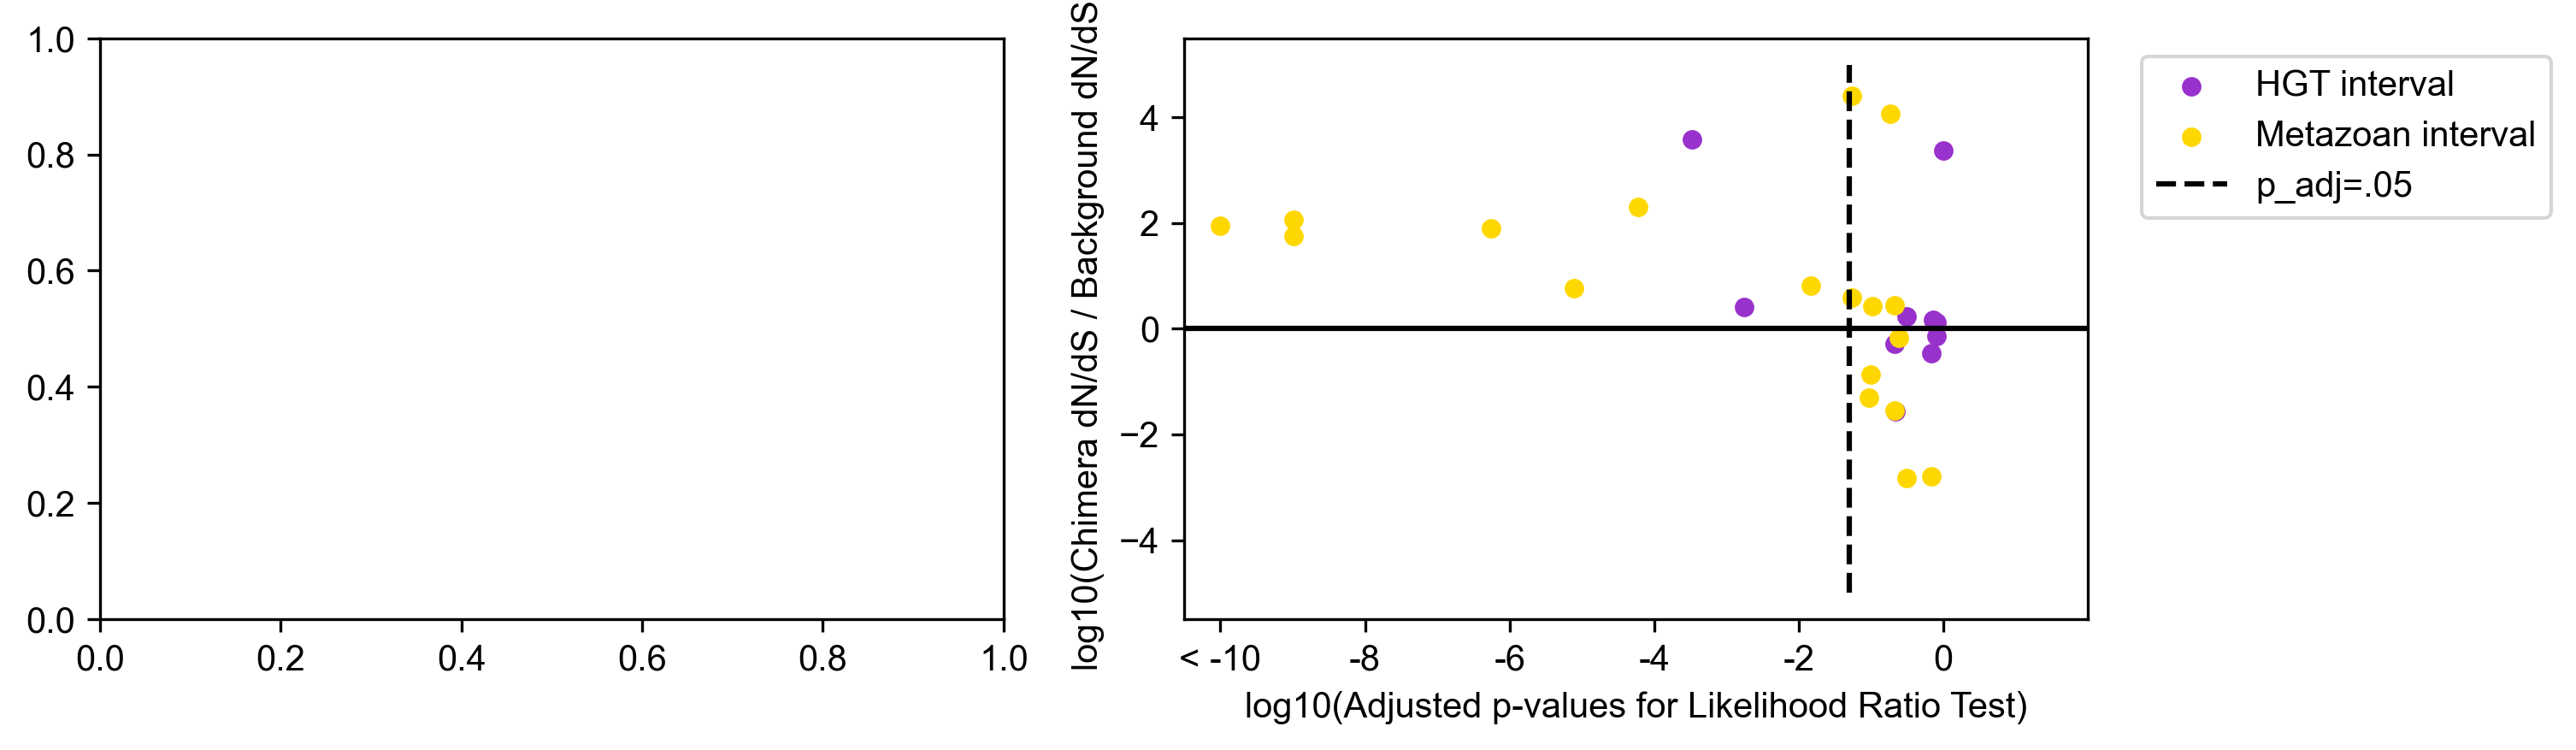

In [36]:
import matplotlib.pyplot as plt
import numpy as np
# Your data and scatter plot
fig,ax=plt.subplots(1,2,dpi=300,figsize=(10,3))
logfc= np.log10(list(dnds_data[dnds_data.index.str.contains("HGT")].dnds_b1 /dnds_data[dnds_data.index.str.contains("HGT")].dnds_b0))
padj=[max(x,-10) for x in np.log10(dnds_data[dnds_data.index.astype(str).str.contains("HGT")].corrected_p_values)]
plt.scatter(padj, logfc,color="darkorchid", s=20,label='HGT interval')

logfc= np.log10(list(dnds_data[~dnds_data.index.str.contains("HGT")].dnds_b1 /dnds_data[~dnds_data.index.str.contains("HGT")].dnds_b0))
padj=[max(x,-10) for x in np.log10(dnds_data[~dnds_data.index.str.contains("HGT")].corrected_p_values)]
ax[1].scatter(padj, logfc, s=20,color='gold',label='Metazoan interval')
# Labeling the axes
ax[1].set_ylabel("log10(Chimera dN/dS / Background dN/dS)")
ax[1].set_xlabel("log10(Adjusted p-values for Likelihood Ratio Test)")

ax[1].vlines(np.log10(.05),-5,5,linestyle='dashed',label="p_adj=.05",color='black')
ax[1].hlines(0,-11,20,color='black')

ax[1].set_xlim(-10.5,2)
# ax[1].set_ylim(-4,4)
custom_ticks=[-10,-8,-6,-4,-2,0]
ax[1].set_xticks(ticks=custom_ticks)
tick_labels = [f"< {tick}" if tick == -10 else tick for tick in custom_ticks]
plt.gca().set_xticklabels(tick_labels)
ax[1].legend( bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig("figures/2branch_dnds_plot.svg",format="svg",bbox_inches="tight", transparent=True)

plt.show()

In [37]:
dnds_data[dnds_data.dnds_b1>dnds_data.dnds_b0].shape[0]

18

In [38]:
dnds_data.shape[0]

28

In [39]:
18/28

0.6428571428571429

In [42]:
dnds_data[(dnds_data.dnds_b1>dnds_data.dnds_b0)&(dnds_data.corrected_p_values<.05)].shape[0]

9